# Implement Online portfolio algorithms directly into the Gyn environment

In [22]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union

class OLMARModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            target_weights: List[float] = None, # If none, default to uniform weights
            window=5, 
            eps=10,
            ) -> None:
        
        # Super simple algorithm, we only need the environment
        # This environment needs to have prices for the OLMAR algorithm TODO check the type here

        assert env is not None 
        self.env = env

        self.window = window
        self.eps = eps

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, (defualt to uniform)
        # Uniform base case
        # Note these are the first weight reprsents the cash account, which should always be 0
        self.current_weights = np.ones(self.portfolio_length-1) / (self.portfolio_length-1)  # target weights for each asset

        # For OLMAR start with uniform and then adjust based on moving averages
        self.price_history = pd.DataFrame()

    def train(self) -> None:
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def learn(
        self
    ):
        # TODO this model is derministic and doesnt learn anything, it only predicts
        pass

    def get_price_relative_SMA(self, window_history):
        """Predict next price relative using SMA."""
        return window_history.mean() / window_history.iloc[-1, :]
        
    def update_weights(self, weights, new_price_prediction):
        """Update portfolio weights to satisfy constraint weights * x >= eps
        and minimize distance to previous weights."""
        price_prediction_mean = np.mean(new_price_prediction)
        excess_return = new_price_prediction - price_prediction_mean
        denominator = (excess_return * excess_return).sum()
        if denominator != 0:
            lam = max(0.0, (self.eps - np.dot(weights, new_price_prediction)) / denominator)
        else:
            lam = 0

        # update portfolio
        weights = weights + lam * (excess_return)

        # project it onto simplex
        return simplex_proj(weights)

# TODO update this code
    def predict(self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # TODO not needed this is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # TODO much of this comes from the policies class in stable baselines
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )

        # Reshape the array to remove single dimensions 
        reshaped_array = observation.reshape(len(self.env._features), self.portfolio_length - 1) 

        # TODO this code his horrible Extract the three lists
        prices = reshaped_array[0].tolist()

        new_row = pd.DataFrame([prices])

        # Add to the price history
        self.price_history = pd.concat([self.price_history, new_row], ignore_index=True)
        old_weights = self.current_weights

        # Normalize the prices
        r = {}
        for name, s in self.price_history.items():
            init_val = s.loc[s.first_valid_index()]
            r[name] = s / init_val
        X = pd.DataFrame(r)

        # Window is too short, return the starting weights
        if len(X) < self.window + 1:
            self.price_prediction = X.iloc[-1]
        else:
            window_history = X.iloc[-self.window :]
            self.price_prediction = self.get_price_relative_SMA(window_history)
            
        new_weights = self.update_weights(old_weights, self.price_prediction)

        self.current_weights = new_weights

        assert np.isclose(self.current_weights.sum(), 1), "The array does not sum up to one."

        # Use the last portfolio as the new action (keep it the same)
        action_weights = np.insert(new_weights, 0, 0)
        actions = action_weights.reshape(1, self.portfolio_length)

        return actions, None

def simplex_proj(y):
    """Projection of y onto simplex."""
    m = len(y)
    bget = False

    s = sorted(y, reverse=True)
    tmpsum = 0.0

    for ii in range(m - 1):
        tmpsum = tmpsum + s[ii]
        tmax = (tmpsum - 1) / (ii + 1)
        if tmax >= s[ii + 1]:
            bget = True
            break

    if not bget:
        tmax = (tmpsum + s[m - 1] - 1) / m

    return np.maximum(y - tmax, 0.0)     

In [23]:


MODELS = {"olmar": OLMARModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
           
            action, _states = model.predict(test_obs, deterministic=deterministic)
            print("HERE!!!!!!!")
            print(action)
            print(type(action))

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [24]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TEST_START_DATE = '2009-02-07'
TEST_END_DATE = '2024-10-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import TEST_TICKER


# # TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# STOCKS = [
#     "AAPL",
#     "MSFT",
#     "V",
# ]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)


from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

environment = PortfolioOptStableEnv(
        portfolio_norm_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

OLMAR_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

OLMAR_model_kwargs = {
    "eps": 60,
    "window": 30
}

# Training
agent_olmar = DRLStableAgent(env = environment)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=OLMAR_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment)
OLMAR_results["training"] = environment._terminal_asset_memory["final"]
OLMAR_results["date"] = environment._terminal_date_memory



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

Shape of DataFrame:  (114173, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.3801231  0.45138847 0.35883802 ... 0.01947727 0.01808933 0.02899626]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.   0.25 0.5  ... 0.75 1.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: 

HERE!!!!!!!
[[0.         0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276
  0.03448276 0.03448276 0.03448276 0.03448276 0.03448276 0.03448276]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 

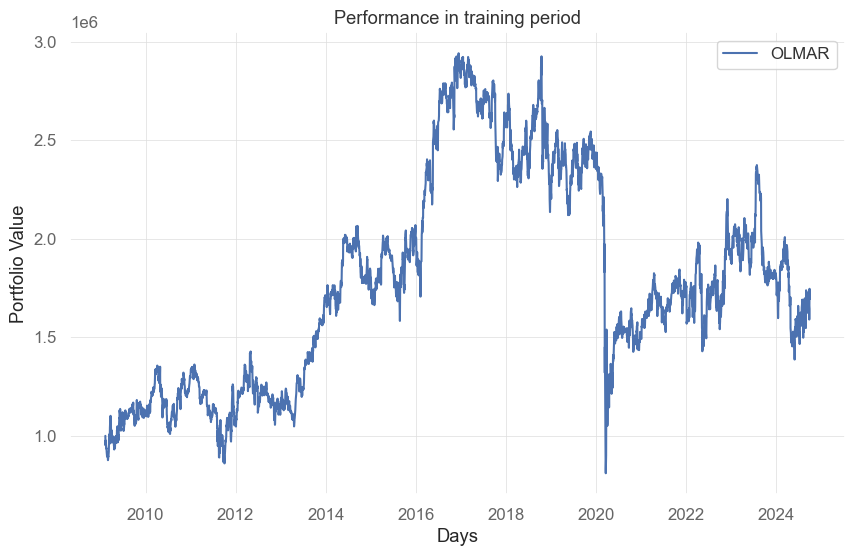

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(OLMAR_results["date"], OLMAR_results["training"], label="OLMAR")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()

tic               AAPL        AMGN         AXP          BA         CAT  \
date                                                                     
2009-02-09    3.091684   41.638947   13.905642   32.426987   21.575764   
2009-02-10    2.950537   40.696144   12.511165   30.464685   20.388828   
2009-02-11    2.920074   41.121475   12.816695   30.555599   20.527300   
2009-02-12    2.993966   41.405014   12.683511   30.199530   20.454767   
2009-02-13    2.990650   41.043499   12.330976   30.669250   20.402016   
...                ...         ...         ...         ...         ...   
2024-09-24  227.369995  330.920013  265.516205  155.809998  384.548370   
2024-09-25  226.369995  312.859985  265.476318  152.220001  376.895874   
2024-09-26  227.520004  319.100006  267.451141  154.580002  389.560364   
2024-09-27  227.789993  322.670013  270.353546  156.320007  389.679932   
2024-09-30  233.000000  322.209991  270.493195  152.039993  389.719788   

tic                CRM       CSCO    

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:243: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method="ffill")


Weights!!!!
AAPL    0.0
AMGN    0.0
AXP     0.0
BA      0.0
CAT     0.0
CRM     0.0
CSCO    0.0
CVX     0.0
DIS     0.0
GS      0.0
HD      0.0
HON     0.0
IBM     0.0
INTC    0.0
JNJ     0.0
JPM     0.0
KO      0.0
MCD     0.0
MMM     0.0
MRK     0.0
MSFT    0.0
NKE     1.0
PG      0.0
TRV     0.0
UNH     0.0
V       0.0
VZ      0.0
WBA     0.0
WMT     0.0
dtype: float64
Price2!!!!
AAPL    1.227490
AMGN    0.825162
AXP     1.439860
BA      0.935747
CAT     1.101418
CRM     1.480291
CSCO    1.146588
CVX     0.896378
DIS     1.126543
GS      1.319864
HD      1.154131
HON     0.939364
IBM     1.065998
INTC    1.058351
JNJ     0.902465
JPM     1.211831
KO      1.028256
MCD     0.911307
MMM     1.076071
MRK     0.804121
MSFT    1.049327
NKE     1.104881
PG      0.941956
TRV     1.022085
UNH     0.797913
V       1.176553
VZ      0.980201
WBA     1.127219
WMT     1.028496
Name: 2009-04-30 00:00:00, dtype: float64
Weights!!!!
AAPL    0.000000
AMGN    0.802879
AXP     0.000000
BA      0.000000

c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\algo.py:252: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = S / S.shift(1).fillna(method="ffill")
c:\Users\bencj\Desktop\Econ4\The

about the convert!!!!!!!!!!!
                    0
date                 
2009-02-09   1.000000
2009-02-10   0.951968
2009-02-11   0.962735
2009-02-12   0.966919
2009-02-13   0.955346
...               ...
2024-09-24  11.197968
2024-09-25  11.140259
2024-09-26  11.212725
2024-09-27  11.275558
2024-09-30  11.267792

[3937 rows x 1 columns]
converted!!!!!!!!!!!
                   0
date                
2009-02-09  1.000000
2009-02-10  0.951968
2009-02-11  1.011311
2009-02-12  1.004346
2009-02-13  0.988031
...              ...
2024-09-24  1.002059
2024-09-25  0.994846
2024-09-26  1.006505
2024-09-27  1.005604
2024-09-30  0.999311

[3937 rows x 1 columns]
about the call weights!!!!!!!!!!!
                   0
date                
2009-02-09  1.000000
2009-02-10  0.951968
2009-02-11  1.011311
2009-02-12  1.004346
2009-02-13  0.988031
...              ...
2024-09-24  1.002059
2024-09-25  0.994846
2024-09-26  1.006505
2024-09-27  1.005604
2024-09-30  0.999311

[3937 rows x 1 columns]


c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\result.py:277: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if x[i] > peak:
c:\Users\bencj\Desktop\Econ4\Thesis\online_algos\result.py:278: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  peak = x[i]


Summary:
    Profit factor: 1.09
    Sharpe ratio: 0.61 ± 0.28
    Ulcer index: 0.77
    Information ratio (wrt benchmark): 0.15
    Benchmark sharpe: 0.99 ± 0.31
    Appraisal ratio (wrt benchmark): -0.03 ± 0.25
    Beta / Alpha: 1.29 / -0.878%
    Annualized return: 20.96%
    Annualized volatility: 34.26%
    Longest drawdown: 1461 days
    Max drawdown: 81.06%
    Winning days: 52.3%
    Annual turnover: 311.5
        
                AAPL      AMGN       AXP        BA       CAT       CRM  \
date                                                                     
2009-02-09  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2009-02-10  0.034483  0.034483  0.034483  0.034483  0.034483  0.034483   
2009-02-11  0.000000  1.000000  0.000000  0.000000  0.000000  0.000000   
2009-02-12  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2009-02-13  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...              ...       ...       ...       ...     

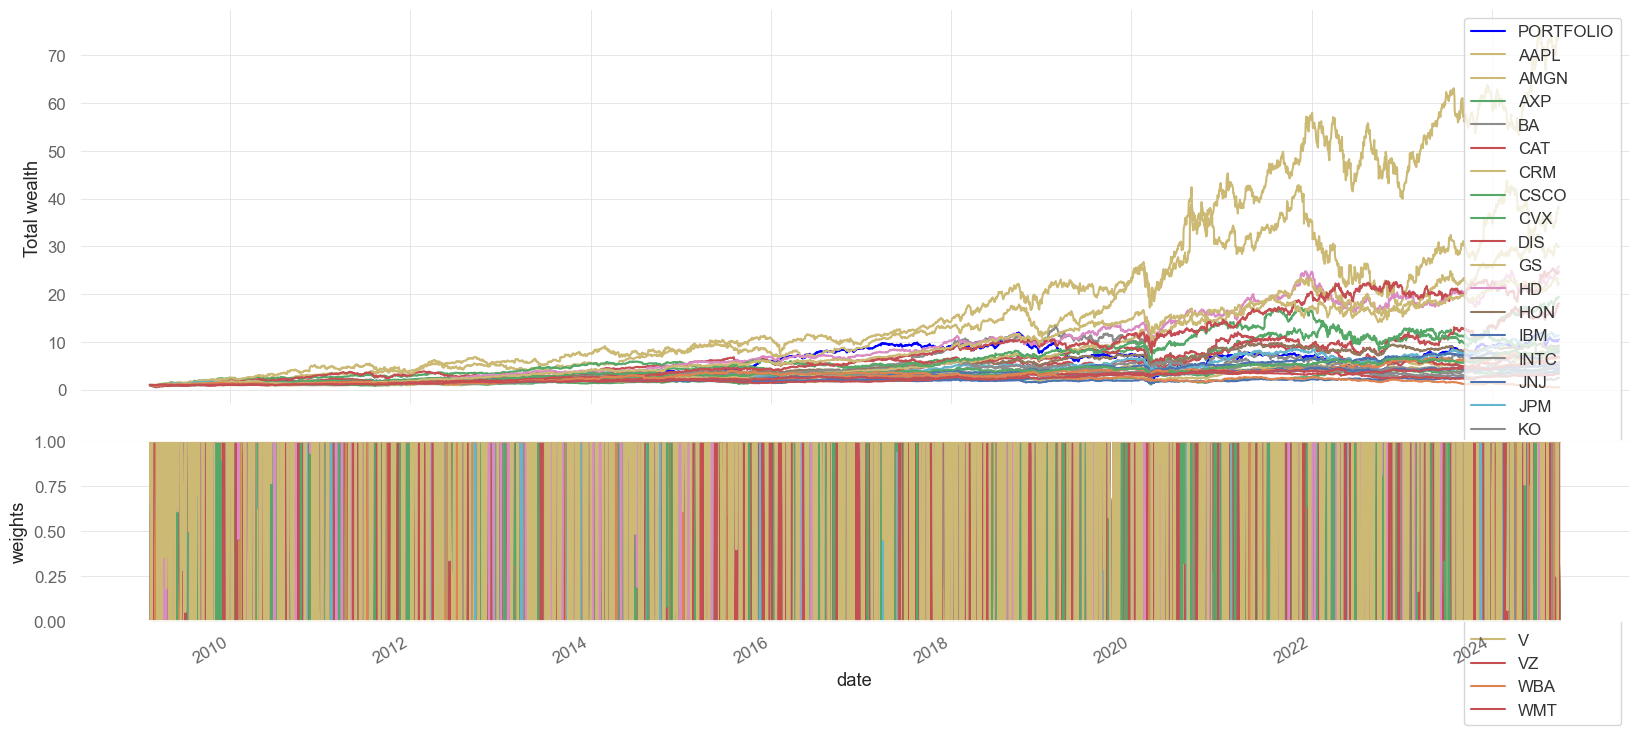

In [26]:
from online_algos import OLMAR

pivot_df = raw_df.pivot(index='date', columns='tic', values='close')

print(pivot_df)

pivot_df.index = pd.to_datetime(pivot_df.index)



algo = OLMAR(window=5, eps=10, ma_type="SMA")

result_olmar = algo.run(pivot_df)
print(result_olmar.summary())
result_olmar.plot()

print(result_olmar.B)

dimensions = result_olmar.B.shape 
print("Dimensions of the DataFrame:", dimensions)

In [27]:
# X = raw_df / raw_df.shift(1).fillna(method="ffill")

# X = X.fillna(1.0)


# pivoted_df = raw_df.pivot(index='date', columns='tic', values='close')
# print(pivoted_df)

print(pivot_df)

X = pivot_df / pivot_df.shift(1).fillna(method="ffill")

X = X.fillna(1.0)
print(X)

tic               AAPL        AMGN         AXP          BA         CAT  \
date                                                                     
2009-02-09    3.091684   41.638947   13.905642   32.426987   21.575764   
2009-02-10    2.950537   40.696144   12.511165   30.464685   20.388828   
2009-02-11    2.920074   41.121475   12.816695   30.555599   20.527300   
2009-02-12    2.993966   41.405014   12.683511   30.199530   20.454767   
2009-02-13    2.990650   41.043499   12.330976   30.669250   20.402016   
...                ...         ...         ...         ...         ...   
2024-09-24  227.369995  330.920013  265.516205  155.809998  384.548370   
2024-09-25  226.369995  312.859985  265.476318  152.220001  376.895874   
2024-09-26  227.520004  319.100006  267.451141  154.580002  389.560364   
2024-09-27  227.789993  322.670013  270.353546  156.320007  389.679932   
2024-09-30  233.000000  322.209991  270.493195  152.039993  389.719788   

tic                CRM       CSCO    

C:\Users\bencj\AppData\Local\Temp\ipykernel_28676\2061739489.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = pivot_df / pivot_df.shift(1).fillna(method="ffill")
